<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/HMC-CaseB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install arviz

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 27kB/s 
     |████████████████████████████████| 327kB 47.8MB/s 


In [1]:

#HMC-CaseB

import numpy as np
import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
from matplotlib import cm
import pystan
import time
import timeit


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Auxiliary functions

def ClassMatrix(x, means):
    temp = np.zeros( shape=(x.shape[0], means.shape[0]) )
    #q = 9.21034 / 100
    for i in range( x.shape[0]):
        temp2=np.zeros( means.shape[0] )
        for j in range( means.shape[0] ):
            temp2[j] =np.dot( x[i] - means[j], x[i] - means[j] )
        index_min = np.argmin(temp2 )
        temp[i][index_min]=1
    return temp

#estimation of weights
def weights(x, means, size):
    #take a sample of size=size and calculate the weights
    indexes = np.random.choice( np.arange( 0, len(x) ), size=size, replace=False )
    temp=ClassMatrix(x[indexes], means)
    return np.mean(temp, 0)


def AFER( fw, tw):
    '''Average frecuency error rate 
    fw: frequency weight
    tw: true weight 
    Calculate \sum| fw-tw | '''
    return np.sum( np.abs(  fw-tw ) )

#nice plot


def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb: array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])

    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()    
    

In [0]:


mu = np.array(
    [[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60],
     [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5],
     [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]] )



num_mixtures = 20 #number of mixture components
dim = 2  # mixture of bivariate Gaussians


#Log target f(x) case b
def log_f(x):
    w = 1/np.sqrt(np.sum(np.square((mu-[5,5])),1))
    v = np.sqrt(np.sum(np.square((mu-[5,5])),1))/20
    return np.log(np.sum((w/v)*np.exp(-1.0/(2.0*v)*np.sum(np.square(x-mu),1))))

T=50000
bi=int(0.15*T)







In [10]:
real_weights=np.zeros(20)
for i in range(20):
  real_weights[i]=1/(  np.sqrt( np.dot(mu[i]-np.array([5,5]),mu[i]-np.array([5,5]))    )   )


real_weights=real_weights/np.sum(real_weights)
print(real_weights)

[0.04579808 0.02276038 0.03755132 0.02810495 0.0337176  0.05754243
 0.02396969 0.18406182 0.06447266 0.06994638 0.05607158 0.03629122
 0.10287907 0.02870615 0.02389351 0.03820911 0.02288663 0.02462541
 0.06906161 0.02945039]


In [11]:

#Standard HMC

dat = {'K': 20,
       'd': 2,
       'w': 1/np.sqrt(np.sum(np.square((mu-[5,5])),1)),
       'mu':mu,
       'sigma': np.sqrt(np.sum(np.square((mu-[5,5])),1))/20}

#Fit Stan model
#remember to upload multimodal_target_1.stan stan file if you do not have it
hmcModel = pystan.StanModel(file="multimodal_target_2.stan")



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62f5756bb70925061a50a5be07a660dc NOW.


In [12]:
fit = hmcModel.sampling(data=dat, iter=T, chains=50, warmup=int(0.15*T) ,n_jobs=4)
output = fit.extract()



In [13]:
sampsHMC = output['theta']

print(fit)

Inference for Stan model: anon_model_62f5756bb70925061a50a5be07a660dc.
50 chains, each with iter=50000; warmup=7500; thin=1; 
post-warmup draws per chain=42500, total post-warmup draws=2125000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   4.52    0.04   1.78   1.14   3.27   4.67    5.5   7.91   2486   1.02
theta[2]   4.91    0.08   2.34   0.08   3.36   5.48   6.13   8.95    887   1.06
lp__      -1.06    0.03   1.47  -4.07  -1.99  -1.12  -0.03   1.65   2747   1.02

Samples were drawn using NUTS at Sat Jun 13 00:59:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
sampsHMC.shape

(2125000, 2)

In [17]:
#takes time, be patient :)

ws_stan=weights( sampsHMC[:,0:2], means= mu, size= sampsHMC.shape[0]  )
ws_stan

array([0.04806212, 0.00208941, 0.03984988, 0.02513365, 0.03761082,
       0.05899435, 0.024528  , 0.19033224, 0.07303812, 0.07752329,
       0.05430494, 0.03957835, 0.10428894, 0.02949647, 0.00210729,
       0.03716141, 0.02194212, 0.02562024, 0.07632235, 0.032016  ])

In [18]:
#modes discovered by 50 different chains

nModes=np.sum(ws_stan>0)
print('Expected Modes discovered : ', nModes)



Expected Modes discovered :  20


In [19]:

print('Expected AFER: ', AFER(ws_stan, real_weights) )

Expected AFER:  0.0983746727781788


In [0]:
xx,yy,Z= fpoints(f= log_f ,args=(0,), theta=(), pars=(),
                  lb= np.array([0,0]), upb= np.array([10, 10]) , m=200 ) #takes time :)






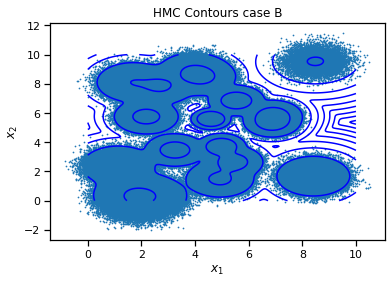

In [21]:

sns.set_context('notebook')

plt.contour( xx, yy, -Z, 10, colors='b' )
plt.scatter( sampsHMC[bi:, 0 ],sampsHMC[bi:, 1 ], s=0.5 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'HMC Contours case B' )
plt.savefig('stanB.png', dpi=500)    
plt.show()    



In [22]:
# What happens when running only one chain

fit2 = hmcModel.sampling(data=dat, iter=T, chains=1, n_jobs=1)
output2 = fit2.extract()

In [23]:
sampsHMC2 = output2['theta']

print(fit2)

Inference for Stan model: anon_model_62f5756bb70925061a50a5be07a660dc.
1 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=25000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   3.82    0.18   1.73   0.85    2.2   4.41   5.06   7.01     94   1.01
theta[2]   3.99    0.71   2.54  -0.28   2.13   3.74   5.74   8.73     13   1.06
lp__       -1.3    0.18   1.43  -4.14  -2.15  -1.44  -0.32   1.58     61   1.04

Samples were drawn using NUTS at Sat Jun 13 01:07:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


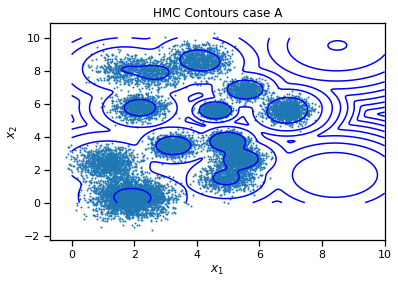

In [25]:
sns.set_context('notebook')

plt.contour( xx, yy, -Z, 10, colors='b' )
plt.scatter( sampsHMC2[bi:, 0 ],sampsHMC2[bi:, 1 ], s=1 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'HMC Contours case A' )
plt.savefig('stanB-onechain.png', dpi=500)    
plt.show() 